In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import custom_module as cm

In [3]:
# Loading the dataset
data = pd.read_csv("/Users/ahsan/Dropbox/My Mac (Alnoors-MBP-2.hub)/Downloads/combined_data.csv", parse_dates=True)

In [4]:
data["SETTLEMENTDATE"] = pd.to_datetime(data["SETTLEMENTDATE"])
data.index = data["SETTLEMENTDATE"]
data.drop(columns="SETTLEMENTDATE", inplace=True)

In [5]:
# The Real Test Data Set To Test Later #
X_test = data["2019-01-01":"2019-06-30"].copy()
X_test = X_test["RRP5MIN"]

In [6]:
# replace outliers by outlier threshold
data = cm.replace_outliers(data, 'RRP5MIN', 5)

In [7]:
data.dropna(inplace=True)
data

,RRP5MIN,RESIDUAL_DEMAND
SETTLEMENTDATE,,
2010-10-20 00:00:00,1.963450,1296.50
2010-10-20 00:05:00,1.955553,1275.46
2010-10-20 00:10:00,1.946951,1268.40
2010-10-20 00:15:00,1.953207,1267.73
2010-10-20 00:20:00,1.835252,1261.69
...,...,...
2019-06-30 23:40:00,5.998145,546.95
2019-06-30 23:45:00,5.961220,560.19
2019-06-30 23:50:00,5.066510,559.87


In [8]:
# Scaling the RRP between 0 and 1 as required by the NN
scaler = MinMaxScaler()
data["RRP5MIN"] = scaler.fit_transform(data["RRP5MIN"].values.reshape(-1,1))

In [9]:
train = pd.DataFrame(data["RRP5MIN"].loc["2017":].copy())

In [10]:
# include time lags of timeseries data for 3 days = 864
# We will use 3 days data to identify patterns to predict the next day

lags = 864
for i in range(1,lags+1):
    train["l_{}".format(i)] = train["RRP5MIN"].shift(i)

In [11]:
# Drop NANS
train.dropna(inplace=True)
train.tail(5)

,RRP5MIN,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,l_855,l_856,l_857,l_858,l_859,l_860,l_861,l_862,l_863,l_864
SETTLEMENTDATE,,,,,,,,,,,,,,,,,,,,,
2019-06-30 23:40:00,0.532301,0.535514,0.504410,0.500036,0.497298,0.517292,0.504057,0.498771,0.472195,0.476271,...,0.475404,0.000000,0.385198,0.459936,0.459342,0.459893,0.437942,0.468562,0.467259,0.478711
2019-06-30 23:45:00,0.531433,0.532301,0.535514,0.504410,0.500036,0.497298,0.517292,0.504057,0.498771,0.472195,...,0.464692,0.475404,0.000000,0.385198,0.459936,0.459342,0.459893,0.437942,0.468562,0.467259
2019-06-30 23:50:00,0.510394,0.531433,0.532301,0.535514,0.504410,0.500036,0.497298,0.517292,0.504057,0.498771,...,0.463457,0.464692,0.475404,0.000000,0.385198,0.459936,0.459342,0.459893,0.437942,0.468562
2019-06-30 23:55:00,0.508886,0.510394,0.531433,0.532301,0.535514,0.504410,0.500036,0.497298,0.517292,0.504057,...,0.477038,0.463457,0.464692,0.475404,0.000000,0.385198,0.459936,0.459342,0.459893,0.437942
2019-07-01 00:00:00,0.510313,0.508886,0.510394,0.531433,0.532301,0.535514,0.504410,0.500036,0.497298,0.517292,...,0.467286,0.477038,0.463457,0.464692,0.475404,0.000000,0.385198,0.459936,0.459342,0.459893


In [12]:
# create feature and label dataframes
prelim_features = train.drop(['RRP5MIN'], axis=1)
prelim_labels = pd.DataFrame(train[['RRP5MIN']])


In [13]:
# format labels to 24 hour output range
for i in range(0, 288):
    prelim_labels['t_{}'.format(i)] = prelim_labels['RRP5MIN'].shift(-i)
prelim_labels.drop(['RRP5MIN'], axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.minute == 0]
labels = labels[labels.index.hour == 0]
features = prelim_features[prelim_features.index.minute == 0]
features = features[features.index.hour == 0]

features_train = features[:'2018']
features_test = features['2019':'2019-06-30']
labels_train = labels[:'2018']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 864

# convert pandas data frames to numpy ndarrays
features_train = features_train.to_numpy().reshape(samples_train, timesteps, 1)
features_test = features_test.to_numpy().reshape(samples_test, timesteps, 1)
labels_train = labels_train.to_numpy()

# check for correct data shape
features_train.shape, labels_train.shape

((727, 864, 1), (727, 288))

In [14]:
from keras.models import Model, load_model
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input

In [15]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

In [22]:
###################### DESIGNING THE NN ###################
##########################################################
## 1D Convolution layer to avoid overfitting
## 3 layers of LSTM considering the complexity of the dataset
# Initialising
rnn = Sequential()
# Adding Conv1D Layer
rnn.add(Conv1D(128, kernel_size=288, strides=288, padding='valid', input_shape=(X_train.shape[1],1)))
# Add LSTM layer 1st
rnn.add(LSTM(200, recurrent_activation='sigmoid', return_sequences=True))
rnn.add(Dropout(0.1))
# Add LSTM layer 2nd
rnn.add(LSTM(128, recurrent_activation='sigmoid'))
rnn.add(Dropout(0.1))
rnn.add(Dense(units=288))
rnn.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [23]:
#model.compile(loss='mae', optimizer='adam')
checkpoint = ModelCheckpoint('./models/multidim_timeseries_testing.hdf5', save_best_only=True)

hist = rnn.fit(X_train, y_train,
                 validation_data=(X_valid, y_valid),
                 callbacks=[checkpoint], 
                 verbose=1, batch_size=32, epochs=160)

Epoch 1/160
19/19 [==============================] - 1s 75ms/step - loss: 0.1442 - mse: 0.1442 - mae: 0.3073 - val_loss: 0.0150 - val_mse: 0.0150 - val_mae: 0.0906
Epoch 2/160
19/19 [==============================] - 1s 32ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.1071 - val_loss: 0.0097 - val_mse: 0.0097 - val_mae: 0.0637
Epoch 3/160
19/19 [==============================] - 1s 34ms/step - loss: 0.0136 - mse: 0.0136 - mae: 0.0868 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0615
Epoch 4/160
19/19 [==============================] - 1s 34ms/step - loss: 0.0127 - mse: 0.0127 - mae: 0.0829 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0606
Epoch 5/160
19/19 [==============================] - 1s 30ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0808 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0640
Epoch 6/160
19/19 [==============================] - 1s 39ms/step - loss: 0.0117 - mse: 0.0117 - mae: 0.0785 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0599
Epoch 7/160
19/1

Epoch 51/160
19/19 [==============================] - 1s 31ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0588 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0531
Epoch 52/160
19/19 [==============================] - 1s 34ms/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0579 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0569
Epoch 53/160
19/19 [==============================] - 1s 34ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0594 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0630
Epoch 54/160
19/19 [==============================] - 1s 28ms/step - loss: 0.0088 - mse: 0.0088 - mae: 0.0668 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0701
Epoch 55/160
19/19 [==============================] - 1s 30ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0596 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0622
Epoch 56/160
19/19 [==============================] - 1s 30ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0596 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0636
Epoch 57/1

19/19 [==============================] - 1s 31ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0525 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0565
Epoch 101/160
19/19 [==============================] - 1s 28ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0538 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0520
Epoch 102/160
19/19 [==============================] - 1s 35ms/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0545 - val_loss: 0.0088 - val_mse: 0.0088 - val_mae: 0.0600
Epoch 103/160
19/19 [==============================] - 1s 33ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0541 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0523
Epoch 104/160
19/19 [==============================] - 1s 28ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0522 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0540
Epoch 105/160
19/19 [==============================] - 1s 32ms/step - loss: 0.0065 - mse: 0.0065 - mae: 0.0545 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0529
Epoch 106/160
19/1

19/19 [==============================] - 1s 27ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0485 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0599
Epoch 150/160
19/19 [==============================] - 1s 28ms/step - loss: 0.0056 - mse: 0.0056 - mae: 0.0496 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0598
Epoch 151/160
19/19 [==============================] - 0s 26ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0493 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0560
Epoch 152/160
19/19 [==============================] - 1s 28ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0481 - val_loss: 0.0078 - val_mse: 0.0078 - val_mae: 0.0567
Epoch 153/160
19/19 [==============================] - 1s 28ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0493 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0569
Epoch 154/160
19/19 [==============================] - 0s 26ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0498 - val_loss: 0.0076 - val_mse: 0.0076 - val_mae: 0.0558
Epoch 155/160
19/1

In [24]:
best = load_model('./models/multidim_timeseries_testing.hdf5')
# pred = best.predict([input_test, input_test[:, :, 3]])
pred = best.predict(features_test)
#pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [26]:
pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))

In [27]:
results = pd.DataFrame({'prediction':pred.flatten(), 'true values':X_test}, index=X_test.index)

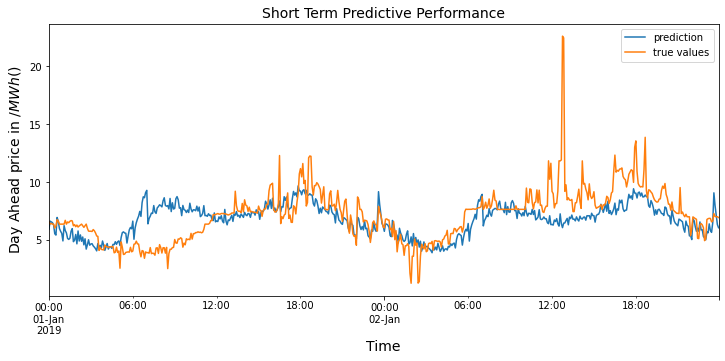

In [28]:
cm.plot_chart(results.loc['2019-01-01':'2019-01-02'], xlab='Time', ylab='Day Ahead price in $/MWh ($)', title='Short Term Predictive Performance', legend=True)

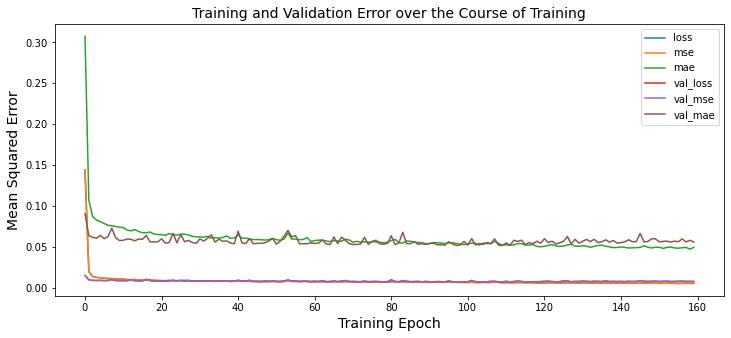

In [29]:
# Training loss comparision
cm.plot_chart(pd.DataFrame(hist.history), xlab='Training Epoch', ylab='Mean Squared Error', title='Training and Validation Error over the Course of Training', legend=True)

In [30]:
# Quantifying Performance using MAE, MSE, RMSE
cm.quantify_performance(results)

MAE:  4.532415022935828
MSE:  2329.5877166431524
RMSE:  48.26580276596622
